In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from numpy import linspace,pi,cos,sin
from scipy.spatial.distance import pdist,squareform
from scipy.stats.mstats import zscore
from scipy.stats import norm,percentileofscore
from math import factorial
import pandas as pd
pd.set_option('max_rows',1000)
import seaborn as sns
import os,sys
from glob import iglob
import matplotlib.patches as mpatches

/Users/mikesivley/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
# Get these definitions out of the way early
def perm(y,N):
  """ Support function for Kest simulations """
  for i in range(N):
    yield np.random.permutation(y)
def Kest(D,y,T=[],P=9999):
  """ Ripley's K-Function Estimator for Spatial Cluster Analysis (w/ Positional Constraints) (w/o Edge Correction)
      D: Distance matrix for all possible point pairs (observed and unobserved)
      y: Weight vector for all possible points (un-observed points must have NaN weight)
      T: Distance thresholds
      P: Number of permutations for simulated confidence envelope
      Caveat: Current implementation only handles positive weights"""
  assert(P!=1)
  y = np.array(y,dtype=np.float64) # for NaN compatibility
  weighted = (y==0).sum()+(y==1).sum() != y[~np.isnan(y)].size
  if not weighted: # convert 0/1 to nan/1
    y[y==0]         = np.nan
    y[~np.isnan(y)] = 1.
  Do  = D[~np.isnan(y),:][:,~np.isnan(y)] # Distance of observed points
  yo  = y[~np.isnan(y)]  # Values of observed points
  R   = y.size           # Number of protein residues
  N   = yo.size          # Number of observed points
  if weighted:
    if P:
      Kest.DT = [Do>=t for t in T] # Precompute distance masks
    Y  = np.outer(yo,yo) # NaN distance diagonal handles i=j pairs
    Y /= Y.sum() # normalize by all-pairs product-sum
    K  =  np.array([np.ma.masked_where(dt,Y).sum() for dt in Kest.DT])
  else:
    K = np.array([(Do<t).sum() for t in T],dtype=np.float64) / (N*(N-1))
  if P:
    if weighted:
      # If weighted, shuffle values for observed points
      K_perm = np.array([Kest(Do,yp,T,P=None) for yp in perm(yo,P)])
    else:
      # If unweighted, shuffle positions for all points
      K_perm = np.array([Kest(D,yp,T,P=None) for yp in perm(y,P)])
    # Add the observed K vector to the permutation matrix
    K_perm = np.concatenate(([K],K_perm))
    # Calculate the simulated z-score 
    K_z = zscore(K_perm)[0]
    if all(np.isnan(K_z)):
      # If all weights are equal, set K_z to 0. rather than NaN
      K_z = np.zeros(K_z.shape[0])
    # Calculate one-sided permutation p-value given K directionality
    p = []
    for i,z in enumerate(K_z):
      if z>0:
        p.append(min(1.,2.*(1.-percentileofscore(K_perm[:,i],K[i],'strict')/100.)))
      else:
        p.append(min(1.,2.*(1.-percentileofscore(-K_perm[:,i],-K[i],'strict')/100.)))
    K_p = p
    K_pz = norm.sf(abs(K_z))*2 # two-sided simulated p-value
    # Calculate the confidence envelope
    hce  = (np.percentile(K_perm,80,axis=0),np.max(K_perm[1:,:],axis=0))
    lce  = (np.percentile(K_perm,20,axis=0),np.min(K_perm[1:,:],axis=0))
    return K,K_p,K_z,K_pz,hce,lce,K_perm
  else:
    return K
Kest.DT = []

def pstat(Pvec):
  """ Calculates a p-value and z-score for the protein-level
      summary statistic. First row of the vector should contain
      the observation. """
  o = Pvec[0] # observed value
  # Calculate the simulation z-score
  o_z = zscore(Pvec)[0]
  P   = np.unique(Pvec).size
  # Calculate one-sided permutation p-values
  o_p = min(1.,min(2*(1.-percentileofscore(-Pvec,-o,'strict')/100.),2*(1.-percentileofscore(Pvec,o,'strict')/100.)))
  o_pz = norm.sf(abs(o_z))*2 # two-sided simulated p-value
  return P,o_p,o_z,o_pz


def k_plot(T,K,Kz,lce,hce,ax=None,w=False):
  if not ax:
    fig,ax = plt.subplots(1,1,figsize=(20,7))
  c = "k"
  # # Min / Max
  # ax.fill_between(T,lce[0],hce[0],alpha=0.1,
  #                     edgecolor=c,facecolor=c,
  #                     interpolate=True,antialiased=True)
  # 99% Confidence
  ax.fill_between(T,lce[1],hce[1],alpha=0.2,
                      edgecolor=c,facecolor=c,
                      interpolate=True,antialiased=True)
  ax.scatter(T,K,s=50,color=c,edgecolor='white',lw=1,label=["Un-Weighted K","Weighted K"][w])
  ax.set_xlim([min(T),max(T)])
  ax.set_xticks([])
  ax.set_yticks([])
  # Add a vertical line a the most extreme threshold
  dK = np.nanmax(np.abs(Kz),axis=0) # studentized maximum K
  t  = np.nanargmax(np.abs(Kz),axis=0) # t where studentized K is maximized
  # dK = np.nanmax([K-hce,lce-K],axis=0) # directional K-99%
  # t  = np.nanargmax(dK) # t where K is most outside the 99% interval
  T,K = T[t],K[t]
#   ax.axvline(T,color=c,lw=2,ls="dashed",label="Optimal T=%.0f"%T)
  return ax

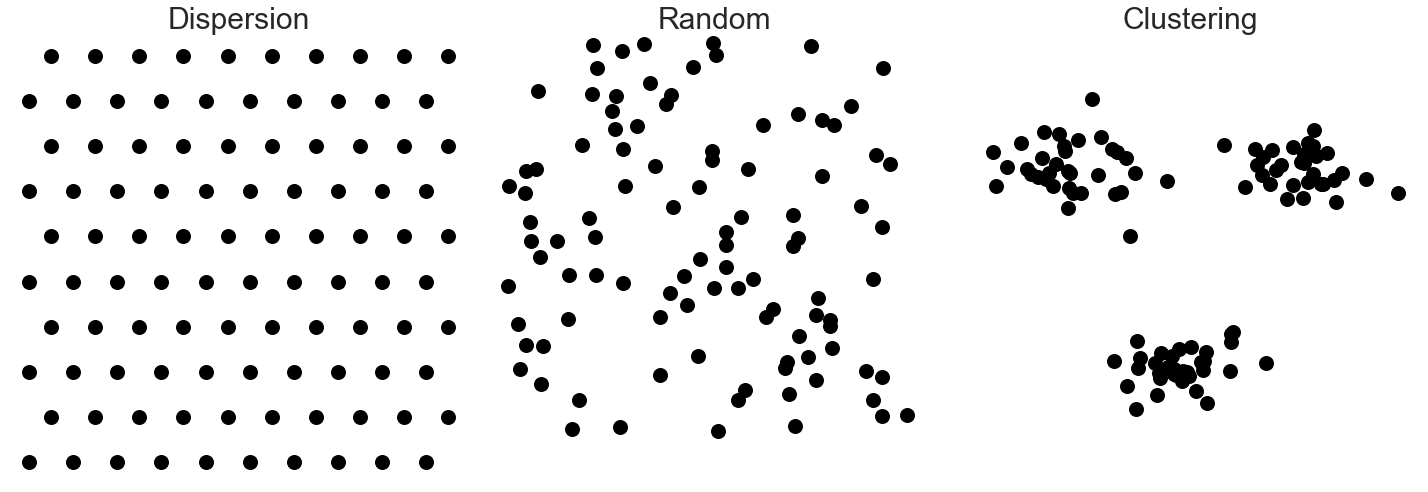

In [3]:
# Construct the very basic demo
fig,ax = plt.subplots(1,3,figsize=(20,7),dpi=300,sharey=True)
# Extreme dispersion
ax[0].set_title("Dispersion",fontsize=30)
x,y = [],[]
for yi in range(10):
    xi = np.arange(0,10) + [0,0.5][yi%2]
    x.extend(xi)
    y.extend([yi]*10)
xD,yD = np.array(x),np.array(y)
ax[0].plot(xD,yD,'o',ls='',markersize=15,c="k")
ax[0].set_xlim([-0.5,10])
ax[0].set_ylim([-0.5,9.5])
# Random 
ax[1].set_title("Random",fontsize=30)
xR,yR = np.random.uniform(0.5,9.5,100),np.random.uniform(0.5,9.5,100)
ax[1].plot(xR,yR,'o',ls='',markersize=15,c='k')
# Extreme clustering
ax[2].set_title("Clustering",fontsize=30)
xC,yC = [],[]
xC.extend(list(np.random.normal(3.5,0.5,33)))
yC.extend(list(np.random.normal(6.5,0.5,33)))
xC.extend(list(np.random.normal(5,0.5,33)))
yC.extend(list(np.random.normal(2,0.5,33)))
xC.extend(list(np.random.normal(6.5,0.5,33)))
yC.extend(list(np.random.normal(6.5,0.5,33)))
xC,yC = np.array(xC),np.array(yC)
ax[2].plot(xC,yC,'o',ls='',markersize=15,c='k')
# ax[2].plot(,,'o',ls='',markersize=15,c='k')
# ax[2].plot(,,'o',ls='',markersize=15,c='k')
ax[0].set_axis_bgcolor('white')
ax[1].set_axis_bgcolor('white')
ax[2].set_axis_bgcolor('white')
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[2].set_xticks([])
ax[2].set_yticks([])
plt.tight_layout()
plt.show()

In [4]:
# Calculate the all-pairs distance matrix for all plots
df = pd.DataFrame({'x':np.concatenate((xD,xR,xC),axis=0),'y':np.concatenate((yD,yR,yC),axis=0)})
df["d"] = [1]*xD.size+[0]*xR.size+[0]*xC.size
df["r"] = [0]*xD.size+[1]*xR.size+[0]*xC.size
df["c"] = [0]*xD.size+[0]*xR.size+[1]*xC.size
D = squareform(pdist(df[["x","y"]].values))
D[np.identity(len(df),dtype=bool)] = np.nan

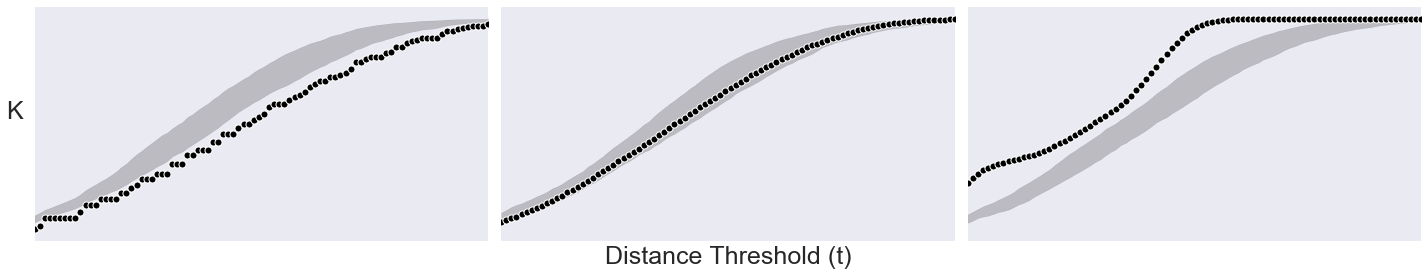

In [5]:
# Generate K plots for each of the three examples
fig,ax = plt.subplots(1,3,figsize=(20,4),dpi=300,sharey=True)
T=np.arange(1,10,0.1)
K,Kp,Kz,Kpz,hce,lce,K_perm = Kest(D,y=df["d"],T=T,P=500)
k_plot(T,K,Kz,lce,hce,ax=ax[0],w=False)
K,Kp,Kz,Kpz,hce,lce,K_perm = Kest(D,y=df["r"],T=T,P=500)
k_plot(T,K,Kz,lce,hce,ax=ax[1],w=False)
K,Kp,Kz,Kpz,hce,lce,K_perm = Kest(D,y=df["c"],T=T,P=500)
k_plot(T,K,Kz,lce,hce,ax=ax[2],w=False)
ax[1].set_xlabel("Distance Threshold (t)",fontsize=25)
ax[0].set_ylabel("K    ",fontsize=25,rotation='horizontal')
plt.tight_layout()
plt.show()

In [6]:
# Define the "protein structure"
x,y = [],[]
for theta in linspace(60,10*pi,num=100):
    r = ((theta)**2)
    x.append(r*cos(theta))
    y.append(r*sin(theta))
x = np.array(x)
y = np.array(y)
df = pd.DataFrame([x,y]).transpose()
df.columns=['x','y']

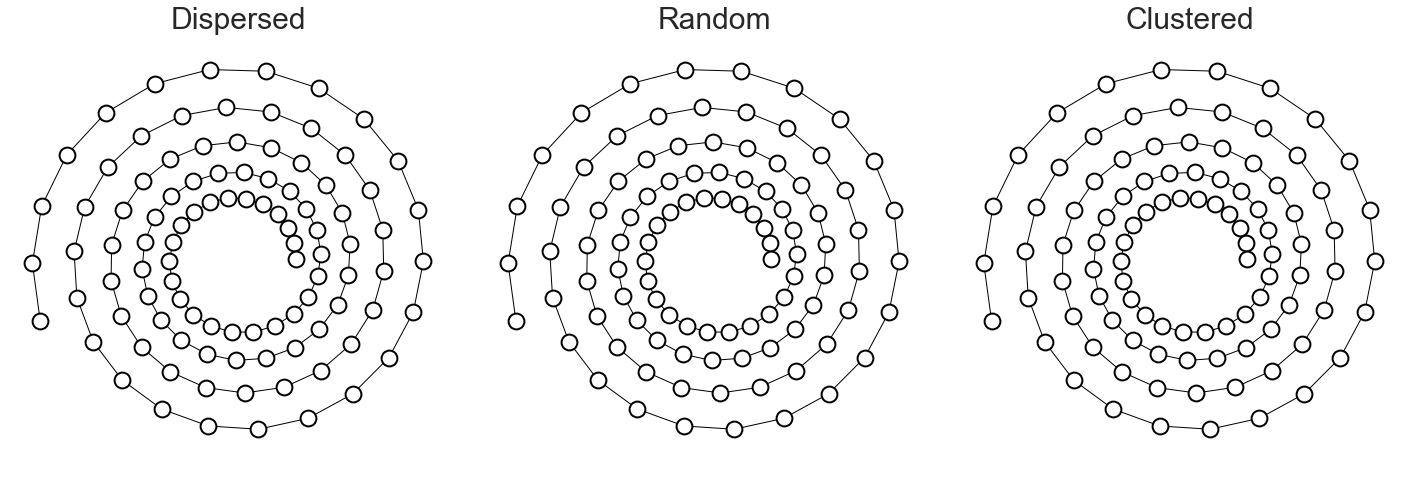

In [7]:
# Plot the "protein" backbone
fig,ax = plt.subplots(1,3,figsize=(20,7),dpi=300,sharey=True)
ax[0].set_axis_bgcolor('white')
ax[1].set_axis_bgcolor('white')
ax[2].set_axis_bgcolor('white')
ax[0].plot(df["x"],df["y"],lw=1,c='k',ls='-',zorder=1)
ax[0].scatter(x=df["x"],y=df["y"],s=250,c='white',color='k',linewidth=2,zorder=2)
ax[1].plot(df["x"],df["y"],lw=1,c='k',ls='-',zorder=1)
ax[1].scatter(x=df["x"],y=df["y"],s=250,c='white',color='k',linewidth=2,zorder=2)
ax[2].plot(df["x"],df["y"],lw=1,c='k',ls='-',zorder=1)
ax[2].scatter(x=df["x"],y=df["y"],s=250,c='white',color='k',linewidth=2,zorder=2)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[2].set_xticks([])
ax[2].set_yticks([])
ax[0].set_title("Dispersed",fontsize=30)
ax[1].set_title("Random",fontsize=30)
ax[2].set_title("Clustered",fontsize=30)
plt.grid(False)
plt.tight_layout()
plt.show()

In [8]:
# Calculate the all-pairs distance matrix for all plots
D = squareform(pdist(df[["x","y"]].values))
D[np.identity(len(df),dtype=bool)] = np.nan

In [82]:
# Generate a dispersed distribution
tdf   = df.copy()
subset = tdf.sample(20)
subset["sub"] = 1
tdf   = tdf.merge(subset,how='left',on=["x","y"])
Ks    = {}
for i in range(5000):
    tdf["sub"] = np.random.permutation(tdf["sub"])
    K,K_p,K_z,K_pz,hce,lce,K_perm = Kest(D,y=tdf["sub"],T=range(1500,3000,100),P=2)
    # Calculate protein summary K
    Ks[np.nansum(K)] = tdf.copy()
minK   = np.nanmin(Ks.keys())
minSub = Ks[minK]
medK   = sorted(Ks.keys())[int(len(Ks)/2.)]
# medK   = int(np.nanmedian(Ks.keys()))
medSub = Ks[medK]
maxK   = np.nanmax(Ks.keys())
maxSub = Ks[maxK]

dispersedc = ["k" if d==1. else "white" for d in minSub["sub"]]
randomc    = ["k" if d==1. else "white" for d in medSub["sub"]]
clusteredc = ["k" if d==1. else "white" for d in maxSub["sub"]]

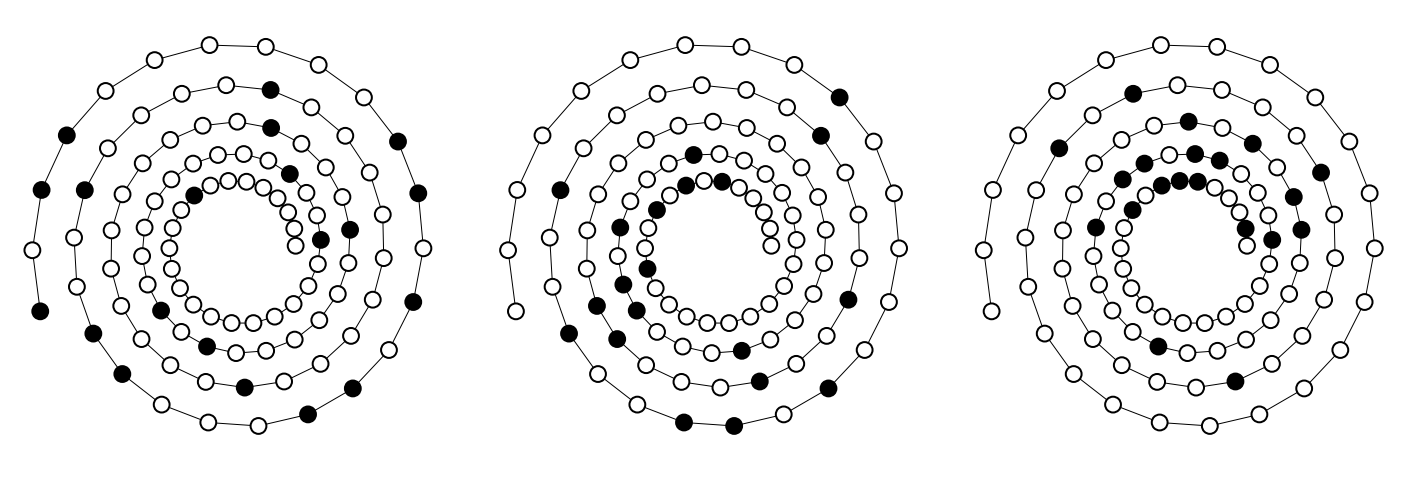

In [83]:
# Plot the "protein" backbone
fig,ax = plt.subplots(1,3,figsize=(20,7),dpi=300,sharey=True)
ax[0].set_axis_bgcolor('white')
ax[1].set_axis_bgcolor('white')
ax[2].set_axis_bgcolor('white')
ax[0].plot(df["x"],df["y"],lw=1,c='k',ls='-',zorder=1)
ax[0].scatter(x=df["x"],y=df["y"],s=250,c=dispersedc,color='k',linewidth=2,zorder=2)
ax[1].plot(df["x"],df["y"],lw=1,c='k',ls='-',zorder=1)
ax[1].scatter(x=df["x"],y=df["y"],s=250,c=randomc,color='k',linewidth=2,zorder=2)
ax[2].plot(df["x"],df["y"],lw=1,c='k',ls='-',zorder=1)
ax[2].scatter(x=df["x"],y=df["y"],s=250,c=clusteredc,color='k',linewidth=2,zorder=2)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[2].set_xticks([])
ax[2].set_yticks([])
plt.grid(False)
plt.tight_layout()
plt.show()

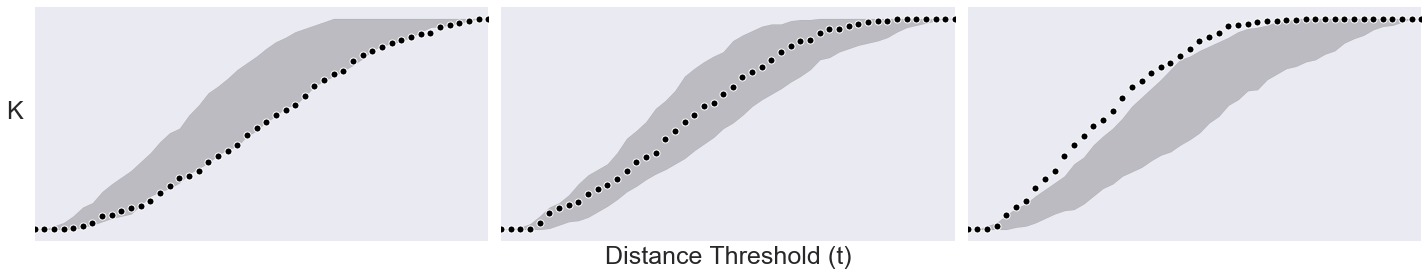

In [84]:
# Generate K plots for each of the three examples
fig,ax = plt.subplots(1,3,figsize=(20,4),dpi=300,sharey=True)
T=range(1,7200,150)
K,Kp,Kz,Kpz,hce,lce,K_perm = Kest(D,y=minSub["sub"],T=T,P=500)
k_plot(T,K,Kz,lce,hce,ax=ax[0],w=False)
K,Kp,Kz,Kpz,hce,lce,K_perm = Kest(D,y=medSub["sub"],T=T,P=500)
k_plot(T,K,Kz,lce,hce,ax=ax[1],w=False)
K,Kp,Kz,Kpz,hce,lce,K_perm = Kest(D,y=maxSub["sub"],T=T,P=500)
k_plot(T,K,Kz,lce,hce,ax=ax[2],w=False)
ax[1].set_xlabel("Distance Threshold (t)",fontsize=25)
ax[0].set_ylabel("K    ",fontsize=25,rotation='horizontal')
plt.tight_layout()
plt.show()

In [69]:
def plot_map(xxyy,xy,ax=None):
    if not ax:
        fig,ax = plt.subplots(1,1,figsize=(10,10))
    xx,yy = xxyy[:,0],xxyy[:,1]
    x,y = xy[:,0],xy[:,1]
    ax.grid(False)
    ax.set_xlim([min(xx)-500,max(xx)+500])
    ax.set_ylim([min(yy)-500,max(yy)+500])
    ax.set_axis_off()
    ax.set_axis_bgcolor("white")
    i = np.random.randint(len(x))
    for r,c in [(0.5e2,'darkorange'),(1.e2,'darkgreen'),(1.5e2,'darkblue'),(2e2,'pink')][::-1]:
        ax.scatter(x[i],y[i],s=r**2,lw=2,facecolor="none",edgecolor=c,linestyle="dashed",alpha=0.5)
    ax.scatter(x,y,s=250,lw=2,facecolor="k",edgecolor="white")
    o_patch = mpatches.Patch(color='darkorange', label='t = 5A')
    g_patch = mpatches.Patch(color='darkgreen',  label='t = 10A')
    b_patch = mpatches.Patch(color='darkblue',   label='t = 15A')
#     ax.legend(handles=[o_patch,g_patch,b_patch],fontsize=15,loc="lower right")

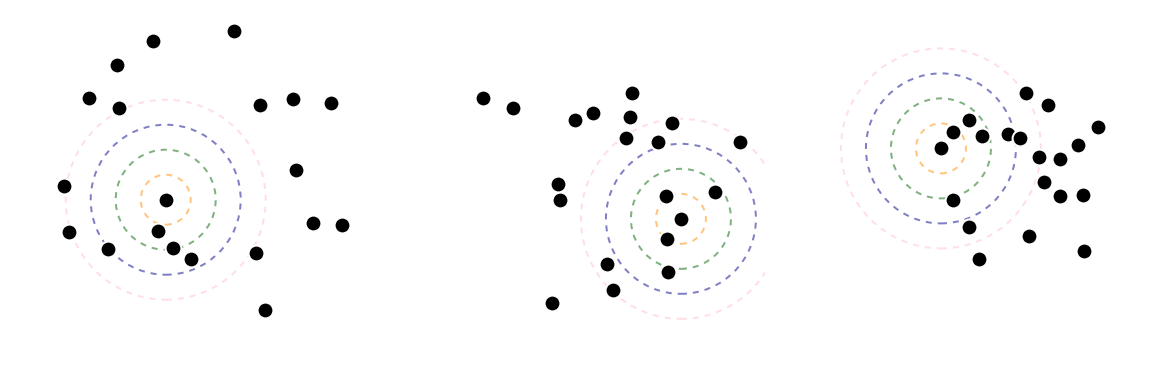

In [70]:
fig,ax = plt.subplots(1,3,figsize=(20,6),dpi=300)
plot_map(minSub[["x","y"]].values,minSub.ix[minSub["sub"]==1,["x","y"]].values,ax=ax[0])
plot_map(medSub[["x","y"]].values,medSub.ix[medSub["sub"]==1,["x","y"]].values,ax=ax[1])
plot_map(maxSub[["x","y"]].values,maxSub.ix[maxSub["sub"]==1,["x","y"]].values,ax=ax[2])
plt.show()

In [14]:
# Possible points
xx = np.random.uniform(0,1,15)
yy = np.random.uniform(0,1,15)
xxyy = np.c_[xx,yy]

In [15]:
# Observed points
x = np.random.uniform(0,1,10)
y = np.random.uniform(0,1,10)
xy = np.c_[x,y]

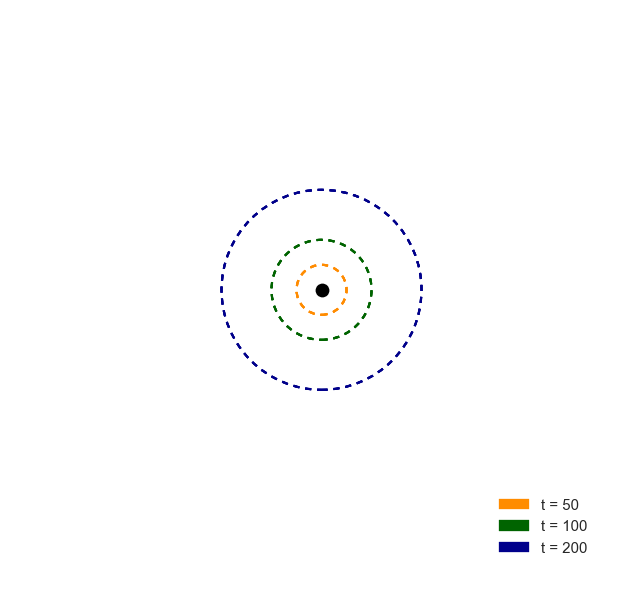

In [16]:
plot_map(xxyy,xy)

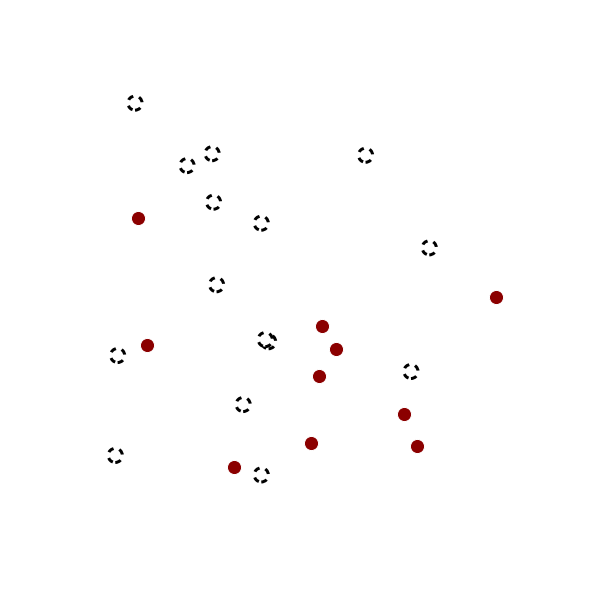

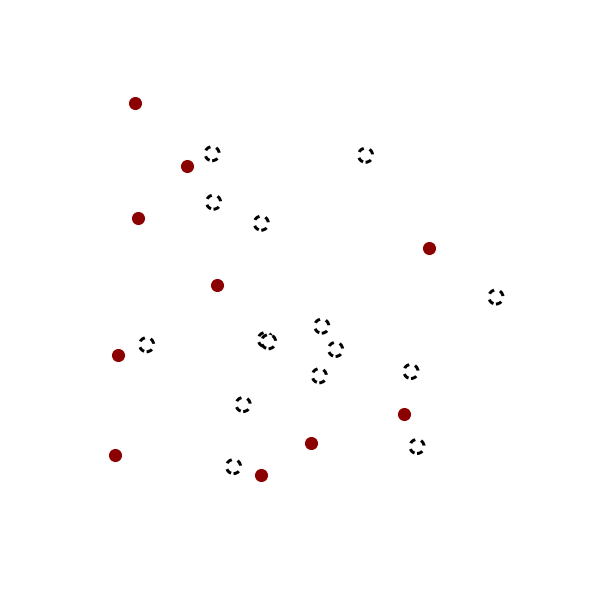

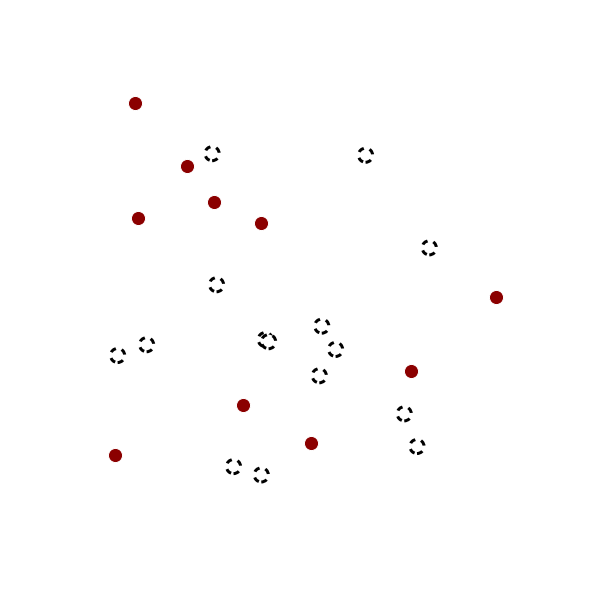

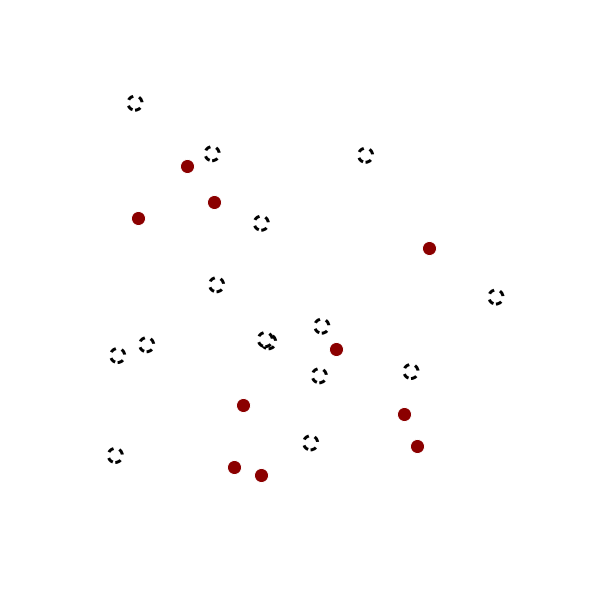

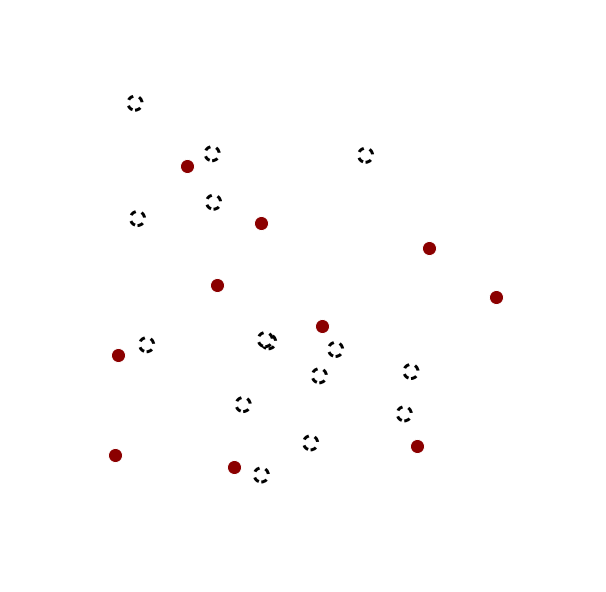

In [17]:
# Permute the positions
def plot_map(xxyy,xy):
    xx,yy = xxyy[:,0],xxyy[:,1]
    x,y   = xy[:,0],xy[:,1]
    fig,ax = plt.subplots(1,1,figsize=(10,10))
    ax.grid(False)
    plt.axis("Off")
    ax.set_axis_bgcolor("white")
    plt.scatter(xx,yy,s=200,lw=3,facecolor="white",edgecolor="black",linestyle="dashed")
    plt.scatter(x,y,s=200,lw=1,facecolor="darkred",edgecolor="white")
    plt.show()
for i in range(5):
    xxxyyy  = np.r_[xxyy,xy]
    np.random.shuffle(xxxyyy)
    xxyy,xy = xxxyyy[:15,:],xxxyyy[15:,:]
    plot_map(xxyy,xy)

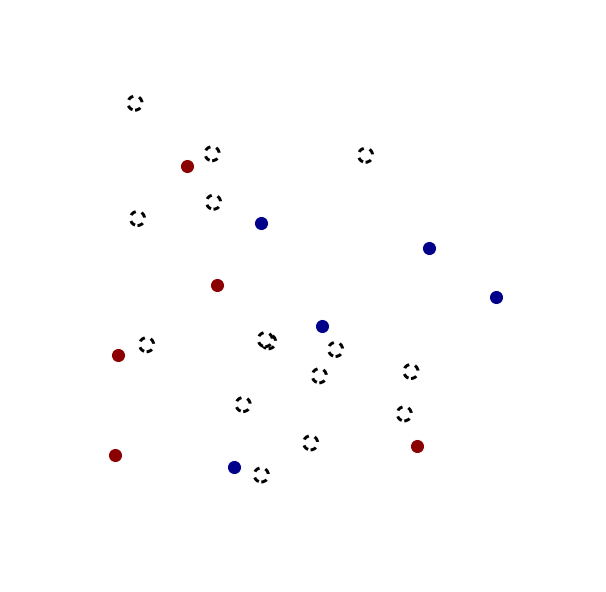

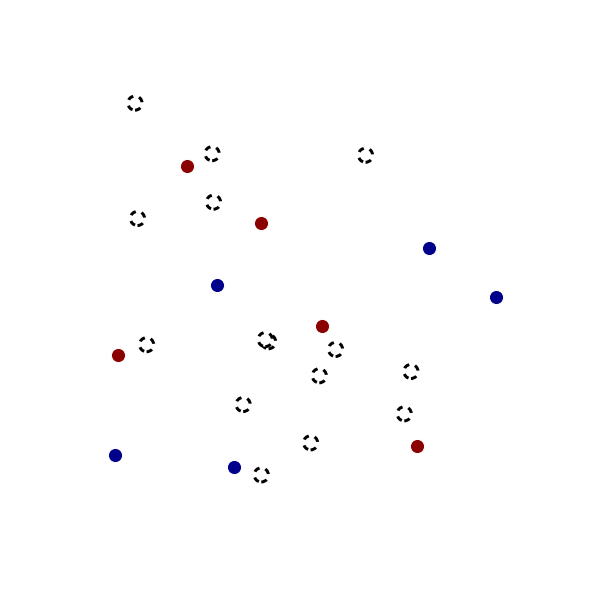

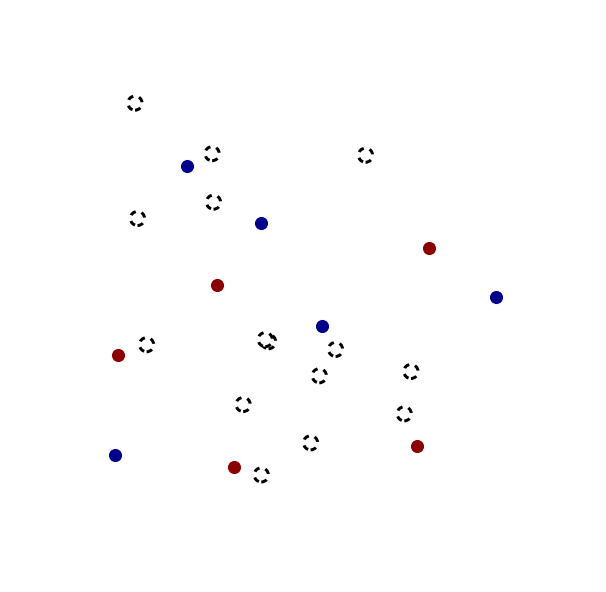

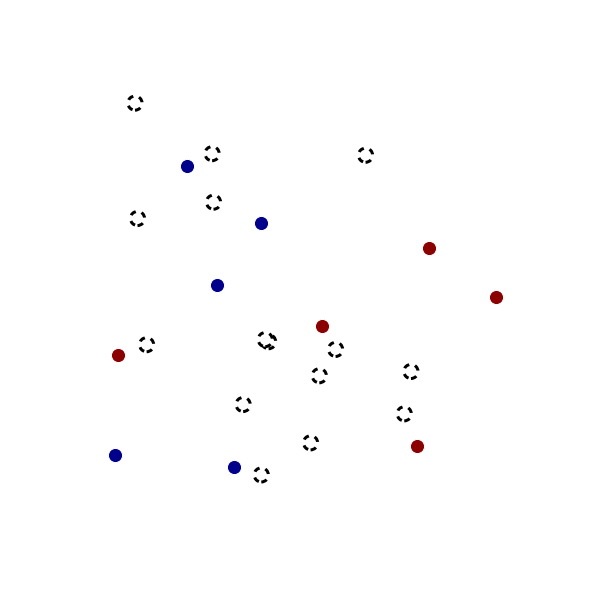

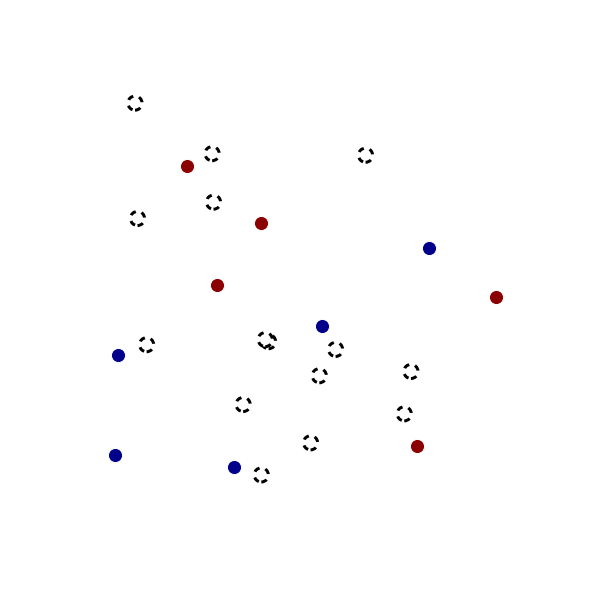

In [18]:
# Permute the labels
def plot_map(xxyy,xy1,xy2):
    xx,yy = xxyy[:,0],xxyy[:,1]
    x1,y1 = xy1[:,0],xy1[:,1]
    x2,y2 = xy2[:,0],xy2[:,1]
    fig,ax = plt.subplots(1,1,figsize=(10,10))
    ax.grid(False)
    plt.axis("Off")
    ax.set_axis_bgcolor("white")
    plt.scatter(xx,yy,s=200,lw=3,facecolor="white",edgecolor="black",linestyle="dashed")
    plt.scatter(x1,y1,s=200,lw=1,facecolor="darkred",edgecolor="white")
    plt.scatter(x2,y2,s=200,lw=1,facecolor="darkblue",edgecolor="white")
    plt.show()
xy1 = xy[:5].copy()
xy2 = xy[5:].copy()
for i in range(5):
    xy  = np.r_[xy1,xy2]
    np.random.shuffle(xy)
    xy1,xy2 = xy[:5,:],xy[5:,:]
    plot_map(xxyy,xy1,xy2)